<a name="intro"></a>
## UGR Dataset Description

The dataset contains network flow within one week. 
#label: 0 - abnormal, 1-normal

# Your Task
You are asked to play three different roles under 3 cases, which will be described in detail below. 

**Make sure you have been assigned a subject ID before you start.**

Your job include:
- Read the case description for each case labeled <b>"[Case Description]"</b> to understand your role in the case
- The descriptions labeled <b>"[Processing]"</b> explain the process of the detection process. **You are not asked to rate them.**
- Go through the explainations (highlighed under the title <b>"[Explaination to Rate]"</b>)
- Rate the helpfulness, correctness and the ease of understanding using this <a href="https://utampa.az1.qualtrics.com/jfe/form/SV_bynXokHkn4wNdt3">link</a>. 
    - Each explanation can be tracked by its id (for example, EC11)


<a name="rule-based-models"></a>
# Case1 [Case Description]

## Data scientist: Boolean Rule and Logistic Rule Regression models
- This case is for people who ideally like to understand the behavior of the model as a whole, not just in specific instances.
- A gloable view of the mdoel may uncover problems with overfitting and poor generalization. 
- You will be provided with two directly interpretable models
    - [Boolean rule (BR)](#BRCG) 
    - [logistic rule regression (LogRR)](#LogRR) 
- While both models are interpretable, they provide different trade-offs between model simplicity and accuracy in predicting loan repayment. BRCG yields a very simple set of rules that has reasonable accuracy. LogRR achieves higher accuracy, higher even than some uninterpretable models, while retaining the form of a linear model. Its interpretation is enhanced by [plots as demonstrated below](#visualize).


### [Processing] Load data
The setting `custom_preprocessing=nan_preprocessing` converts special values in the data (coded as negative integers) to `np.nan`, which can be handled properly by BRCG and LogRR, as opposed to replacing them with zeros or mean values. The data is then split into training and test sets using a fixed random seed.

In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas

# Load FICO HELOC data with special values converted to np.nan
from aix360.datasets.ugr_dataset import UGRDataset, nan_preprocessing
data = UGRDataset(custom_preprocessing=nan_preprocessing).data()

print(data.shape)
#data.head()

data.rename( columns={'Unnamed: 0':'ID'}, inplace=True )

data.head()


Using UGR dataset:  /home/ec2-user/aix360/AIX-UGR/aix360/datasets/../data/heloc_data/ugr_dataset.csv
(556770, 11)


,ID,Timestamp,FlowDuration,SrcIP,DstIP,SrcPort,DstPort,Protocol,TypeofService,PacketExed,Label
0,0,68400,0.0,3229037509,719035615,25,33017,1,0.0,0.0,0
1,1,68400,0.0,3229037509,719035607,25,44777,1,0.0,0.0,0
2,2,68400,0.0,3229037509,719035606,25,49952,1,0.0,0.0,0
3,3,68400,0.0,3291408581,719035604,25,49006,1,0.0,0.0,0
4,4,68400,0.0,3291408581,719035605,25,38350,1,0.0,0.0,0


In [24]:

# Separate target variable
y = data.pop('Label')

data.pop('ID')
data.head()

,Timestamp,FlowDuration,SrcIP,DstIP,SrcPort,DstPort,Protocol,TypeofService,PacketExed
0,68400,0.0,3229037509,719035615,25,33017,1,0.0,0.0
1,68400,0.0,3229037509,719035607,25,44777,1,0.0,0.0
2,68400,0.0,3229037509,719035606,25,49952,1,0.0,0.0
3,68400,0.0,3291408581,719035604,25,49006,1,0.0,0.0
4,68400,0.0,3291408581,719035605,25,38350,1,0.0,0.0


In [25]:

# Split data into training and test sets using fixed random seed
from sklearn.model_selection import train_test_split
dfTrain, dfTest, yTrain, yTest = train_test_split(data, y, random_state=0, stratify=y)
dfTrain.head().transpose()

,263352,212814,190274,523994,346398
Timestamp,0.000000e+00,8.280000e+04,3.600000e+04,18000.0,7.200000e+03
FlowDuration,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
SrcIP,1.816330e+09,1.545504e+09,2.403863e+09,732176440.0,3.592995e+09
DstIP,7.190356e+08,7.190355e+08,7.190361e+08,719034591.0,7.190346e+08
SrcPort,2.500000e+01,8.000000e+01,5.300000e+01,80.0,2.842900e+04
DstPort,4.108000e+04,1.292400e+04,3.454800e+04,45019.0,5.300000e+01
Protocol,1.000000e+00,1.000000e+00,2.000000e+00,1.0,2.000000e+00
TypeofService,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
PacketExed,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00


### [Processing]: Binarizing data
BRCG and LogRR require non-binary features to be binarized using the provided `FeatureBinarizer` class. We use the default of nine quantile thresholds (i.e. 10 bins) to binarize ordinal (including continuous-valued) features, include all negations (e.g. '>' comparisons as well as '<='), and also return standardized versions of the original unbinarized ordinal features, which are used by LogRR but not BRCG. Below is the result of binarizing the first 'ExternalRiskEstimate' feature. 

In [26]:
# Binarize data and also return standardized ordinal features
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(negations=True, returnOrd=True)
print(fb)
dfTrain, dfTrainStd = fb.fit_transform(dfTrain)
dfTest, dfTestStd = fb.transform(dfTest)
print(dfTrain['SrcIP'].head())



operation           <=                                                      \
value     9.533475e+08 1.201833e+09 1.816330e+09 2.403863e+09 2.764158e+09   
263352               0            0            1            1            1   
212814               0            0            1            1            1   
190274               0            0            0            1            1   
523994               1            1            1            1            1   
346398               0            0            0            0            0   

operation                                                   >               \
value     3.077044e+09 3.394151e+09 3.584567e+09 9.533475e+08 1.201833e+09   
263352               1            1            1            1            1   
212814               1            1            1            1            1   
190274               1            1            1            1            1   
523994               1            1            1            0  

<a name="BRCG"></a>
## [Processing] Run Boolean Rule Column Generation (BRCG)
First we consider BRCG, which is designed to produce a very simple OR-of-ANDs rule (known more formally as disjunctive normal form, DNF) or alternatively an AND-of-ORs rule (conjunctive normal form, CNF) to predict whether an applicant will repay the loan on time (Y = 1). For a binary classification problem such as we have here, a DNF rule is equivalent to a *rule set*, where AND clauses in the DNF correspond to individual rules in the rule set. Furthermore, it can be shown that a CNF rule for Y = 1 is equivalent to a DNF rule for Y = 0 [[1]](https://ieeexplore.ieee.org/document/7738856). BRCG is distinguished by its use of the optimization technique of column generation to search the space of possible clauses, which is exponential in size. To learn more about column generation, please see our NeurIPS paper [[2]](http://papers.nips.cc/paper/7716-boolean-decision-rules-via-column-generation). 

For this dataset, we find that a CNF rule for Y = 1 (i.e. a DNF for Y = 0, enabled by setting `CNF=True`) is slightly better than a DNF rule for Y = 1. The model complexity parameters `lambda0` and `lambda1` penalize the number of clauses in the rule and the number of conditions in each clause. We use the default values of 1e-3 for `lambda0` and `lambda1` (decreasing them did not increase accuracy here) and leave other parameters at their defaults as well. The model is then trained, evaluated, and printed.

In [28]:
# Instantiate BRCG with small complexity penalty and large beam search width
from aix360.algorithms.rbm import BooleanRuleCG
br = BooleanRuleCG(lambda0=1e-3, lambda1=1e-3, CNF=True)

# Train, print, and evaluate model

br.fit(dfTrain, yTrain)


Learning CNF rule with complexity parameters lambda0=0.001, lambda1=0.001


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/minicon

Initial LP solved
Iteration: 1, Objective: 0.1978


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/minicon

Iteration: 2, Objective: 0.1124


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/minicon

Iteration: 3, Objective: 0.0971


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/minicon

Iteration: 4, Objective: 0.0967


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/minicon

Iteration: 5, Objective: 0.0847


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
/home/ec2-user/minicon

## [Explanation to Rate] ID: EC11

Please rate the following explanation in the survey. Its id is **EC11**

In [29]:
from sklearn.metrics import accuracy_score
print('Training accuracy:', accuracy_score(yTrain, br.predict(dfTrain)))
print('Test accuracy:', accuracy_score(yTest, br.predict(dfTest)))
print('Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:')
print(br.explain()['rules'])

Training accuracy: 0.9162549661499556
Test accuracy: 0.9148448557039506
Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:
['DstIP <= 719036092.00 AND DstIP > 719035603.00', 'SrcIP <= 953347517.00 AND DstIP > 719036245.00 AND DstPort <= 53.00', 'SrcIP <= 1816330183.00 AND SrcPort <= 443.00 AND Protocol <= 1.00 AND PacketExed <= 0.00']


In [6]:
import socket
import struct
def convert_int_ip(ipint):
    #ipint=16909060
    return socket.inet_ntoa(struct.pack('!L', ipint))
    
def convert_ip(ipstr):
    if ipstr.strip == "":
        return 0
    return struct.unpack("!L", socket.inet_aton(ipstr.strip()))[0]


print('The string format of IP 719036092 is ', convert_int_ip(719036092))
print('The string format of IP 953347517 is ', convert_int_ip(953347517))
print('The string format of IP 719036245 is ', convert_int_ip(719036245))
print('The string format of IP 1816330183 is ', convert_int_ip(1816330183))


The string format of IP 719036092 is  42.219.158.188
The string format of IP 953347517 is  56.210.237.189
The string format of IP 719036245 is  42.219.159.85
The string format of IP 1816330183 is  108.66.255.199


<a name="LogRR"></a>
### [Processing] Run Logistic Rule Regression (LogRR)
Next we consider a LogRR model, which can improve accuracy at the cost of a more complex but still interpretable model. Specifically, LogRR fits a logistic regression model using rule-based features, where column generation is again used to generate promising candidates from the space of all possible rules. Here we are also including unbinarized ordinal features (`useOrd=True`) in addition to rules. Similar to BRCG, the complexity parameters `lambda0`, `lambda1` penalize the number of rules included in the model and the number of conditions in each rule. the The values for `lambda0`, `lambda1` below strike a good balance between accuracy and model complexity.

In [30]:
# Instantiate LRR with good complexity penalties and numerical features
from aix360.algorithms.rbm import LogisticRuleRegression
lrr = LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)

# Train, print, and evaluate model
lrr.fit(dfTrain, yTrain, dfTrainStd)
print('Training accuracy:', accuracy_score(yTrain, lrr.predict(dfTrain, dfTrainStd)))
print('Test accuracy:', accuracy_score(yTest, lrr.predict(dfTest, dfTestStd)))


/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/beam_search.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zOut = pd.Series(index=X.columns)
/home/ec2-user/miniconda3/envs/aix360/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/beam_search.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  zOut = pd.Series

Training accuracy: 0.9343019371277632
Test accuracy: 0.9326115537419267


## [Explanation to Rate] ID: EC12

Please rate the following explanation in the survey. Its id is **EC12**

In [31]:
print('Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))')
print('where z is a linear combination of the following rules/numerical features:')
lrr.explain()

Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))
where z is a linear combination of the following rules/numerical features:


,rule/numerical feature,coefficient
0,(intercept),4.20428
1,DstIP <= 719036245.00 AND DstIP > 719034752.00...,-5.00598
2,DstIP,-4.2817
3,DstIP <= 719035603.00,4.08223
4,SrcIP > 953347517.00 AND DstIP <= 719036245.00...,-3.46479
5,DstIP <= 719036092.00,-3.19106
6,DstIP <= 719036245.00 AND DstIP > 719035603.00...,2.72289
7,SrcIP > 953347517.00 AND DstIP <= 719036245.00...,-2.61972
8,SrcPort <= 443.00,-2.51284
9,DstPort <= 53.00,-2.28951


<a name="visualize"></a>
### [Processing] Visualize LogRR model as a Generalized Additive Model (GAM)
We use the `visualize()` method of `LogisticRuleRegression` to plot the functions in the GAM that corresponds to the LogRR model (more generally, `visualize()` plots the GAM part of a LogRR model, excluding higher-degree rules). The plots show the sizes and shapes of the model's dependences on individual features. These can then be compared to a lending expert's knowledge. In the present case, all plots indicate that the model behaves as we would expect with some interesting nuances. 



## [Explanation to Rate] ID: EC13
- Please go through the following several plots that shows the sizes and shapes of the model's dependaences on individual features. 
- Rate them in general in the survey. The id is **EC13**

In [39]:
dfx = lrr.explain()
#print(dfx)
# Separate 1st-degree rules into (feature, operation, value) to count unique features
#dfx2 = dfx['rule/numerical feature'].str.split(' ', expand=True)
dfx2 = dfx['rule/numerical feature'].str.split(' ', expand=True)
#print(dfx2)
dfx2.columns = ['feature1','operation','value', 'connector', 'feature2', 'operation', 'value', 'connector', 'feature3', 'operation', 'value',  'connector', 'feature3', 'operation', 'value']
#print(dfx2['feature1'].nunique())# includes intercept
#print(dfx2['feature2'].nunique())# includes intercept

print(lrr)

LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)


It follows that there are several functions to plot, which we organize into semantic groups below to ease interpretation.

/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


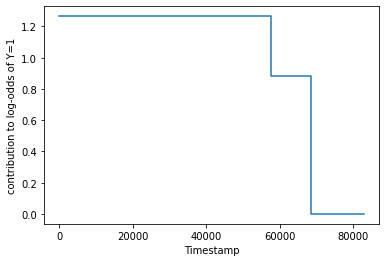

In [40]:
lrr.visualize(data, fb, ['Timestamp']);

In [43]:
#lrr.visualize(data, fb, ['FlowDuration']);

/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


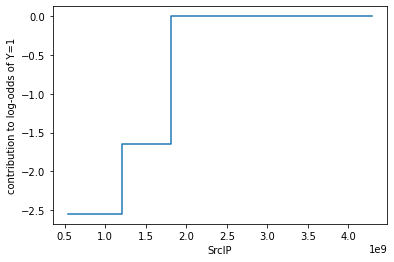

In [44]:
lrr.visualize(data, fb, ['SrcIP']);


/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


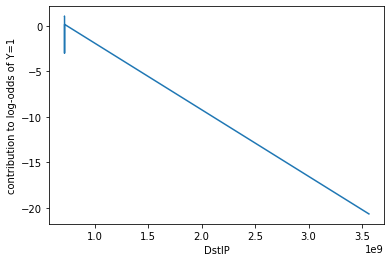

In [45]:
lrr.visualize(data, fb, ['DstIP']);

/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


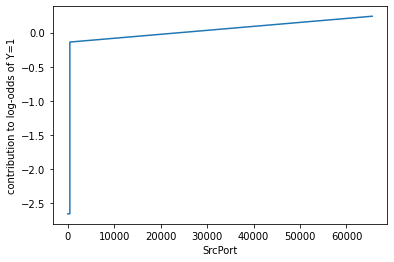

In [46]:
lrr.visualize(data, fb, ['SrcPort']);

/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


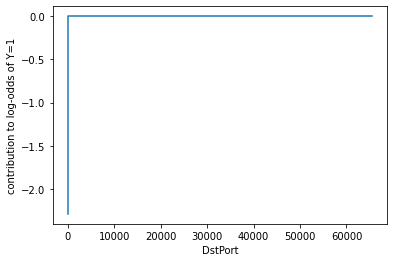

In [47]:
lrr.visualize(data, fb, ['DstPort']);

In [48]:
lrr.visualize(data, fb, ['Protocol']);


/home/ec2-user/aix360/AIX-UGR/aix360/algorithms/rbm/logistic_regression.py:351: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  terms = pd.Series(index=pd.MultiIndex.from_arrays([[],[],[]], names=self.z.index.names))


In [52]:
lrr.visualize(data, fb, ['TypeofService']);

In [53]:
lrr.visualize(data, fb, ['PacketExed']);

<a name="prototypes"></a>
# Case 2

## [Case Description]
## Prototypical explanations for use case

- In this case, you no long care about the model itself. Instead, you are interested in the selected prototypical or similar netflow profiles.
- The selected prototypical explanations  may help you understand the decision of a network flow being determined as normal or abnormal.



We will see two examples of obtaining prototypes:
- One for a network flow identified as normal
- Another for a network flow identified as abnormal. 
- In each case, we showcase the top five prototypes from the training data along with how similar the feature values were for these prototypes.




### [Processing] Import statements

Import necessary libraries, frameworks and algorithms.

In [30]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.ugr_dataset import UGRDataset

### [Processing]  Load UGR dataset and show sample applicants

In [31]:
heloc = UGRDataset()
df = heloc.dataframe()
df.rename( columns={'Unnamed: 0':'ID'}, inplace=True )
#df.pop('ID')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of UGR dataset:", df.shape)
print("Number of \"Normal\" connection:", np.sum(df['Label']==1))
print("Number of \"Abnormal\" connection:", np.sum(df['Label']==0))
print("Sample connections:")
df.head(10).transpose()

Using UGR dataset:  /home/ec2-user/aix360/UGR-processing/AIX-UGR/aix360/datasets/../data/heloc_data/ugr_dataset.csv
Size of UGR dataset: (556770, 11)
Number of "Normal" connection: 278385
Number of "Abnormal" connection: 278385
Sample connections:


,0,1,2,3,4,5,6,7,8,9
ID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00
Timestamp,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04
FlowDuration,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SrcIP,3.229038e+09,3.229038e+09,3.229038e+09,3.291409e+09,3.291409e+09,3.291409e+09,3.291409e+09,3.291409e+09,1.816330e+09,3.230619e+09
DstIP,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08
SrcPort,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
DstPort,3.301700e+04,4.477700e+04,4.995200e+04,4.900600e+04,3.835000e+04,3.789500e+04,3.955800e+04,5.745200e+04,5.718900e+04,3.500900e+04
Protocol,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
TypeofService,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
PacketExed,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [39]:
df.shape

(556770, 11)

Distribution of several features:


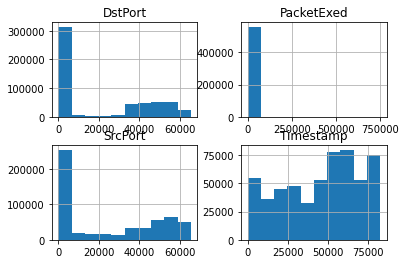

In [33]:
# Plot (example) distributions for two features
print("Distribution of several features:")
hist = df.hist(column=['PacketExed', 'Timestamp', 'SrcPort','DstPort'], bins=10)

<a name="c1"></a>
### [Processing] Process and Normalize  dataset for training



#### [Processing]  a. Process the dataset

In [34]:
# Clean data and split dataset into train/test
(Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()
#print(y_test_b)




#### [Processing] b. Normalize the dataset

In [35]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

<a name="c2"></a>
### [Processing]  Define and train a NN classifier

Let us now build a loan approval model based on the HELOC dataset.

#### a. Define NN architecture
We now define the architecture of a 2-layer neural network classifier whose predictions we will try to interpret. 

In [40]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model    

#### [Processing]  b. Train the NN

In [41]:
# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['0', '1']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = False

if (TRAIN_MODEL): 
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=20, verbose=1, shuffle=False)
    nn.save_weights("ugr_nnsmall.h5")     
else:    
    nn.load_weights("ugr_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 22        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
417577/417577 [==============================] - 3s 6us/step - loss: 0.1294 - acc: 0.9633
Epoch 2/20
417577/417577 [==============================] - 2s 5us/step - loss: 0.0214 - acc: 0.9965
Epoch 3/20
417577/417577 [==============================] - 2s 5us/step - loss: 0.0097 - acc: 0.9983
Epoch 4/20
417577/417577 [==============================] - 2s 5us/step - loss: 0.0051 - acc: 0.9990
Epoch 5/20
417577/417577 [==============================] - 2s 5us/step - loss: 0.0032 - acc: 0.9993
Epoch 6/20
41

<a name="good"></a>
### [Processing]  Obtain similar samples as explanations for a UGR applicant predicted as "background" (Example 1)

#### [Processing] a. Normalize the data and chose a particular applicant, whose profile is displayed below.

In [42]:
p_train = nn.predict_classes(xn_train) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xn_train, p_train)) # Store (normalized) instances that were predicted as Good
z_train_good = z_train[z_train[:,-1]==1, :]


zun_train = np.hstack((x_train, p_train)) # Store (unnormalized) instances that were predicted as Good 
zun_train_good = zun_train[zun_train[:,-1]==1, :]
print(z_train_good)

[[ 0.44113358 -0.2826087  -0.5        ... -0.5        -0.5
   1.        ]
 [ 0.12215748 -0.41304348 -0.5        ... -0.5        -0.5
   1.        ]
 [ 0.03902426  0.36956522 -0.5        ... -0.5        -0.5
   1.        ]
 ...
 [ 0.40889579  0.02173913 -0.5        ... -0.5        -0.5
   1.        ]
 [ 0.18959658  0.36956522 -0.5        ... -0.5        -0.5
   1.        ]
 [ 0.41467197 -0.41304348 -0.5        ... -0.5        -0.5
   1.        ]]


### [Description] Let us now consider one network connection which was identified as normal.



In [43]:

idx = 8

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)

print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

# attach the prediction made by the model to X
X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

Xun = x_test[idx].reshape((1,) + x_test[idx].shape) 
dfx = pd.DataFrame.from_records(Xun.astype('double')) # Create dataframe with original feature values
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()


Chosen Sample: 8
Prediction made by the model: 1
Prediction probabilities: [[-101.04285  100.61301]]



,0
ID,520243
Timestamp,72000
FlowDuration,0
SrcIP,6.06452e+08
DstIP,7.19034e+08
SrcPort,48663
DstPort,22
Protocol,1
TypeofService,0
PacketExed,0


####  [Processing] Find similar network connections predicted as "normal" 

In [44]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=5) # Return weights W, Prototypes S and objective function values

#### [Processing]  Display similar network connections and the extent to which they are similar to the chosen netowrk connection as indicated by the last row in the table below labelled as "Weight".

In [45]:
dfs = pd.DataFrame.from_records(zun_train_good[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

,0,1,2,3,4
ID,522444,279145,280716,296966,517132
Timestamp,72000,82800,0,0,82800
FlowDuration,0,0,0,0.992,0
SrcIP,6.06452e+08,6.27128e+08,6.07267e+08,6.27129e+08,3.6607e+09
DstIP,7.19036e+08,7.19036e+08,7.19036e+08,7.19036e+08,7.19036e+08
SrcPort,48663,51167,3008,65337,64365
DstPort,22,80,1976,443,50321
Protocol,1,1,1,1,2
TypeofService,0,0,0,0,0
PacketExed,0,0,0,8,0


#### [Processing] Compute how similar a feature of a prototypical network connection is to the chosen network connection.
The more similar the feature of prototypical network connection is to the chosen  network connection, the closer its weight is to 1. We can see below that several features for prototypes are quite similar to the chosen  network connection. A human friendly explanation is provided thereafter.


## [Explanation to Rate] ID: EC21
The following table depicts the five closest  network connection to the chosen  network connection. 
- The more similar the feature of prototypical network connection is to the chosen network connection, the closer its importance weight is to 1. 
- Pay attention to the feature similarity table above, how many  features of this prototype are identical to that of the chosen network connection.  
- You want to look at the prototypical network connections and their features surmises that the approved network connection belongs to a group of normal netowrk connections.

Do you think the above table give you more confidence in deciding the chosen network connection is normal?



Rate the following explanations as a whole in the survey. The id is **EC21**

In [46]:
z = z_train_good[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()        

,0,1,2,3,4
ID,0.98,0.12,0.12,0.14,0.97
Timestamp,1.00,0.76,0.16,0.16,0.76
FlowDuration,1.00,1.00,1.00,0.08,1.00
SrcIP,1.00,0.98,1.00,0.98,0.08
DstIP,0.00,0.00,0.00,0.00,0.00
SrcPort,1.00,0.90,0.13,0.48,0.50
DstPort,1.00,1.00,0.91,0.98,0.08
Protocol,1.00,1.00,1.00,1.00,0.08
TypeofService,1.00,1.00,1.00,1.00,1.00
PacketExed,1.00,1.00,1.00,0.08,1.00


<a name="bad"></a>
### [Description] Example 2. Obtaining similar samples as explanations for a connection predicted as "abnoral". 
We now consider a network connection identified as abnormal. We obtained a contrastive explanation for this netowrk connection before. 

Steps similar to example 1 are followed in this case too, where we first process the data, obtain prototypes and their importance weights, and finally showcase how similar the features are of these prototypes to the user we want to explain.

#### [Processing] Normalize the data and chose a particular applicant, whose profile is displayed below.

In [47]:
z_train_bad = z_train[z_train[:,-1]==0, :]
zun_train_bad = zun_train[zun_train[:,-1]==0, :]

In [48]:
idx = 272 #another user to try 2385

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

# move samples to a dataframe to display
Xun = x_test[idx].reshape((1,) + x_test[idx].shape)
dfx = pd.DataFrame.from_records(Xun.astype('double'))
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()

Chosen Sample: 272
Prediction made by the model: 0
Prediction probabilities: [[ 228.92514 -230.83737]]



,0
ID,144421
Timestamp,61200
FlowDuration,0
SrcIP,2.40386e+09
DstIP,7.19036e+08
SrcPort,53
DstPort,54898
Protocol,2
TypeofService,0
PacketExed,0


#### [Processing] Find similar applicants predicted as "bad" using the protodash explainer. 

In [49]:
(W, S, setValues) = explainer.explain(X, z_train_bad, m=5) # Return weights W, Prototypes S and objective function values

#### [Processing]  Display similar applicant user profiles and the extent to which they are similar to the chosen applicant as indicated by the last row in the table below labelled as "Weight".

In [50]:
# move samples to a dataframe to display
dfs = pd.DataFrame.from_records(zun_train_bad[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_bad[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Compute normalized importance weights for prototypes
dfs.transpose()

,0,1,2,3,4
ID,144550,17241,227889,48848,207395
Timestamp,61200,75600,10800,82800,82800
FlowDuration,0,8.576,0,0,0
SrcIP,2.40386e+09,3.59318e+09,5.41699e+08,4.11502e+09,5.45091e+08
DstIP,7.19036e+08,7.19036e+08,7.19035e+08,7.19036e+08,7.19036e+08
SrcPort,53,1794,0,53,60999
DstPort,54984,80,771,63173,80
Protocol,2,1,3,2,1
TypeofService,0,0,0,0,0
PacketExed,0,3,2,0,0


#### [Processing] Compute how similar a feature of a prototypical user is to the chosen applicant.


## [Explanation to Rate] ID: EC22
The following table depicts the closest network connections to the chosen network connection. 
- The more similar the feature of prototypical network connection is to the chosen network connection, the closer its importance weight is to 1. 
- Pay attention to the feature similarity table above, how many  eatures of this prototype are identical to that of the chosen network connection.  
- You want to look at the prototypical network connections and their features surmises that the approved network connection belongs to a group of abnormal netowrk connections.



Do you think the above table give you more confidence in deciding the chosen network connection is abnormnal?



Rate the following explanations as a whole in the survey. The id is **EC22**



In [51]:
z = z_train_bad[S, 0:-1] # Store the prototypes
eps = 1e-10 # Small constant to guard against divide by zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]): # Compute feature similarity for each prototype
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps))
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()        

,0,1,2,3,4
ID,1.0,0.22,0.37,0.32,0.47
Timestamp,1.0,0.59,0.16,0.45,0.45
FlowDuration,1.0,0.08,1.00,1.00,1.00
SrcIP,1.0,0.45,0.29,0.32,0.29
DstIP,1.0,1.00,0.09,0.66,1.00
SrcPort,1.0,0.93,1.00,1.00,0.08
DstPort,1.0,0.15,0.15,0.75,0.15
Protocol,1.0,0.26,0.26,1.00,0.26
TypeofService,1.0,1.00,1.00,1.00,1.00
PacketExed,1.0,0.09,0.21,1.00,1.00


<a name="contrastive"></a>
# Case 3
## [Case Description]
## Customer: Contrastive explanations

In this case, you are taking another role with the interest in the contrastive explanations. 
- You may want to underdatand why a network flow is identified as abnormal and if so what changes in the network flow features would make them normal. 
- The contrastive explanations can help you understand the decisions made by AI models that netowrk flow being identified as normal or abnormal.



The three main steps to obtain a contrastive explanation are shown below. The first two steps are more about processing the data and building an AI model while the third step computes the actual explanation. 

 [Step 1. Process and Normalize dataset for training](#c1)<br>
 [Step 2. Define and train a NN classifier](#c2)<br>
 [Step 3. Compute contrastive explanations for a few applicants](#c3)<br>


### [Processing] Load  dataset and show sample applicants

In [54]:
import warnings
warnings.filterwarnings('ignore')

heloc = UGRDataset()
df = heloc.dataframe()

df.rename( columns={'Unnamed: 0':'ID'}, inplace=True )
#df.pop('ID')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of UGR dataset:", df.shape)
print("Number of \"Normal\" connections:", np.sum(df['Label']=='normal'))
print("Number of \"Abnormal\" connections:", np.sum(df['Label']=='abnormal'))
print("Sample Connections:")
df.head(10).transpose()

Using UGR dataset:  /home/ec2-user/aix360/UGR-processing/AIX-UGR/aix360/datasets/../data/heloc_data/ugr_dataset.csv
Size of UGR dataset: (556770, 11)
Number of "Normal" connections: 0
Number of "Abnormal" connections: 0
Sample Connections:


,0,1,2,3,4,5,6,7,8,9
ID,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,9.000000e+00
Timestamp,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04,6.840000e+04
FlowDuration,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
SrcIP,3.229038e+09,3.229038e+09,3.229038e+09,3.291409e+09,3.291409e+09,3.291409e+09,3.291409e+09,3.291409e+09,1.816330e+09,3.230619e+09
DstIP,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08,7.190356e+08
SrcPort,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01,2.500000e+01
DstPort,3.301700e+04,4.477700e+04,4.995200e+04,4.900600e+04,3.835000e+04,3.789500e+04,3.955800e+04,5.745200e+04,5.718900e+04,3.500900e+04
Protocol,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
TypeofService,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
PacketExed,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Distribution of several features:


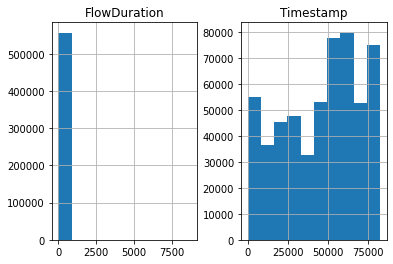

In [55]:
# Plot (example) distributions for two features
print("Distribution of several features:")
hist = df.hist(column=['FlowDuration', 'Timestamp'], bins=10)

<a name="c1"></a>
###  [Processing]  Step 1. Process and Normalize  dataset for training


####  [Processing]  a. Process the dataset

In [56]:
# Clean data and split dataset into train/test
PROCESS_DATA = True

if (PROCESS_DATA): 
    (Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()
    np.savez('heloc.npz', Data=Data, x_train=x_train, x_test=x_test, y_train_b=y_train_b, y_test_b=y_test_b)
else:
    heloc = np.load('heloc.npz', allow_pickle = True)
    Data = heloc['Data']
    x_train = heloc['x_train']
    x_test  = heloc['x_test']
    y_train_b = heloc['y_train_b']
    y_test_b  = heloc['y_test_b']



####  [Processing]  b. Normalize the dataset

In [57]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

<a name="c2"></a>
###  [Processing] Step 2. Define and train a NN classifier

Let us now build a loan approval model based on the HELOC dataset.

####  [Processing] a. Define NN architecture
We now define the architecture of a 2-layer neural network classifier whose predictions we will try to interpret. 

In [60]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model    

####  [Processing] b. Train the NN

In [62]:
# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['background', 'blacklist']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = False

if (TRAIN_MODEL):             
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=20, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 22        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
417577/417577 [==============================] - 3s 6us/step - loss: 0.1294 - acc: 0.9633
Epoch 2/20
417577/417577 [==============================] - 2s 5us/step - loss: 0.0214 - acc: 0.9965
Epoch 3/20
417577/417577 [==============================] - 2s 5us/step - loss: 0.0097 - acc: 0.9983
Epoch 4/20
417577/417577 [==============================] - 2s 6us/step - loss: 0.0051 - acc: 0.9990
Epoch 5/20
417577/417577 [==============================] - 2s 6us/step - loss: 0.0032 - acc: 0.9993
Epoch 6/20
4

<a name="c3"></a>
###  [Description] Step 3. Compute contrastive explanations for a few applicants

Given the trained NN model to decide on IDS approvals, let us first examine a network connection identified as abnormal and what (minimal) changes to it would lead to normal (i.e. finding pertinent negatives). We will then look at another network connection which was identified as normal and ascertain features that would minimally suffice in it still getting a positive outcome (i.e. finding pertinent positives).

####  [Processing] a. Compute Pertinent Negatives (PN): 

 This will help you understand how a network connection was initially identified as abnormal could be determined normal after a few changes in features. 

In [63]:
# Some interesting user samples to try: 2344 449 1168 1272
idx = 272

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.1 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder

# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)

Computing PN for Sample: 272
Prediction made by the model: [[ 228.92493 -230.8372 ]]
Prediction probabilities: background


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
iter:0 const:[10.]
Loss_Overall:1.6122, Loss_Attack:0.0000
Loss_L2Dist:1.3947, Loss_L1Dist:2.1755, AE_loss:0.0
target_lab_score:-112.0976, max_nontarget_lab_score:111.6150

iter:500 const:[10.]
Loss_Overall:1.4691, Loss_Attack:0.0000
Loss_L2Dist:1.2738, Loss_L1Dist:1.9530, AE_loss:0.0
target_lab_score:-112.5294, max_nontarget_lab_score:112.0456

iter:0 const:[5.]
Loss_Overall:0.9434, Loss_Attack:0.0000
Loss_L2Dist:0.8000, Loss_L1Dist:1.4341, AE_loss:0.0
target_lab_score:-113.3124, max_nontarget_lab_score:112.8245

iter:500 const:[5.]
Loss_Overall:0.8074, Loss_Attack:0.0000
Loss_L2Dist:0.6928, Loss_L1Dist:1.1469, AE_loss:0.0
target_lab_score:-113.8065, max_nontarget_lab_score:113.3166

iter:0 co

[Description] Let us start by examining one particular network flow that was identified as abnormal.  We showcase below how the decision could have been different through minimal changes to the profile. We also indicate the importance of different features to produce the change in the application status. The column delta in the table below indicates the necessary deviations for each of the features to produce this change. A human friendly explanation is then provided based on these deviations following the feature importance plot.

In [64]:
Xpn = adv_pn
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]

print("Sample:", idx)
print("prediction(X)", nn.predict_proba(X), class_names[np.argmax(nn.predict_proba(X))])
print("prediction(Xpn)", nn.predict_proba(Xpn), class_names[np.argmax(nn.predict_proba(Xpn))] )


X_re = rescale(X) # Convert values back to original scale from normalized
Xpn_re = rescale(Xpn)
Xpn_re = np.around(Xpn_re.astype(np.double), 2)

delta_re = Xpn_re - X_re
delta_re = np.around(delta_re.astype(np.double), 2)
delta_re[np.absolute(delta_re) < 1e-4] = 0

X3 = np.vstack((X_re, Xpn_re, delta_re))

dfre = pd.DataFrame.from_records(X3) # Create dataframe to display original point, PN and difference (delta)
dfre[23] = classes

dfre.columns = df.columns
dfre.rename(index={0:'X',1:'X_PN', 2:'(X_PN - X)'}, inplace=True)
dfret = dfre.transpose()


def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
    return(['background-color: white']*ncols)

dfret.style.apply(highlight_ce, col='(X_PN - X)', ncols=3, axis=1) 

Sample: 272
prediction(X) [[ 228.92493 -230.8372 ]] background
prediction(Xpn) [[-0.24824496  0.17593123]] blacklist


,X,X_PN,(X_PN - X)
ID,144421.000000,278412.710000,133991.710000
Timestamp,61200.000000,61200.000000,0.000000
FlowDuration,0.000000,0.000000,0.000000
SrcIP,2403862665.000000,2403862715.500000,50.500000
DstIP,719036092.000000,719036050.830000,-41.170000
SrcPort,53.000000,53.000000,0.000000
DstPort,54898.000000,54898.000000,0.000000
Protocol,2.000000,2.000000,0.000000
TypeofService,0.000000,0.000000,0.000000
PacketExed,0.000000,0.000000,0.000000


Now let us compute the importance of different PN features that would be instrumental in this network connection receiving a favorable outcome and display below.

## [Explanation to Rate] ID: EC31

In the following output, you will observe that the network connection would have been identified as normal if the values of some features have some changes. 


The follwoing changes to the suggested factors are also intuitively consistent in improving the chances of acceptance of a network connection. 

One must realize that the above explanation is for the particular network connection based on what the model would do and does not necessarily have to agree with their intuitive meaning. In fact, if the explanation is deemed unacceptable then its an indication that perhaps the model should be debugged/updated_.



Rate the following explanations as a whole in the survey. The id is **EC31**



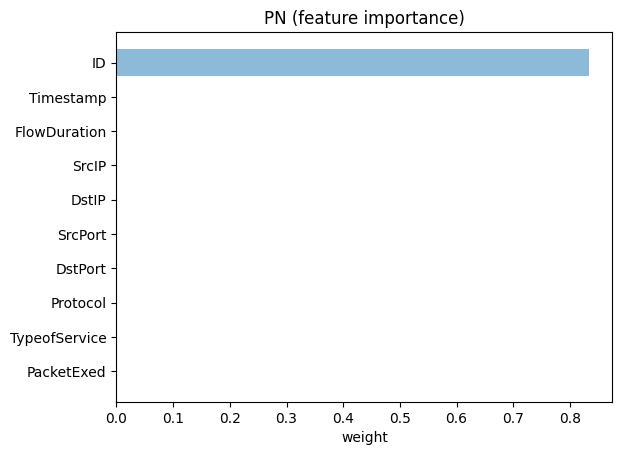

In [65]:
plt.rcdefaults()
fi = abs((X-Xpn).astype('double'))/np.std(xn_train.astype('double'), axis=0) # Compute PN feature importance
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects))
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # bar chart
plt.yticks(y_pos, objects) # Display features on y-axis
plt.xlabel('weight') # x-label
plt.title('PN (feature importance)') # Heading

plt.show() # Display PN feature importance

####  [Processing] Compute Pertinent Positives (PP):
In order to compute pertinent positives, the CEM explainer identifies a minimal set of features along with their values (as close to 0) that would still maintain the predicted loan application status of the applicant.

In [66]:
# Some interesting user samples to try: 8 9 11
idx = 8

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PP for Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")


mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PP' # Find pertinent positives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.1 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder

(adv_pp, delta_pp, info_pp) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)

Computing PP for Sample: 8
Prediction made by the model: blacklist
Prediction probabilities: [[-101.04304  100.61326]]

iter:0 const:[10.]
Loss_Overall:0.0000, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6010, max_nontarget_lab_score:-0.6245

iter:500 const:[10.]
Loss_Overall:0.0000, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6010, max_nontarget_lab_score:-0.6245

iter:0 const:[5.]
Loss_Overall:0.0000, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6010, max_nontarget_lab_score:-0.6245

iter:500 const:[5.]
Loss_Overall:0.0000, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6010, max_nontarget_lab_score:-0.6245

iter:0 const:[2.5]
Loss_Overall:0.0000, Loss_Attack:0.0000
Loss_L2Dist:0.0000, Loss_L1Dist:0.0000, AE_loss:0.0
target_lab_score:0.6010, max_nontarget_lab_score:-0.6245

iter:500 const:[2.5]
Loss_Overall

For the pertinent positives, we look at a different applicant 8 whose loan application was approved. We want to ascertain here what minimal values for this profile would still have lead to acceptance. Below, we showcase the pertinent positive as well as the important features in maintaining the approved status. The 0s in the PP column indicate that those features were not important. The 0s in the PP column indicate that those features were not important. Here too, we provide a human friendly explanation following the feature importance plot.

In [67]:
Xpp = delta_pp
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpp))]]

print("PP for Sample:", idx)
print("Prediction(Xpp) :", class_names[np.argmax(nn.predict_proba(Xpp))])
print("Prediction probabilities for Xpp:", nn.predict_proba(Xpp))
print("")

X_re = rescale(X) # Convert values back to original scale from normalized
adv_pp_re = rescale(adv_pp)
Xpp_re = X_re - adv_pp_re
Xpp_re = np.around(Xpp_re.astype(np.double), 2)
Xpp_re[Xpp_re < 1e-4] = 0

X2 = np.vstack((X_re, Xpp_re))

dfpp = pd.DataFrame.from_records(X2.astype('double')) # Showcase a dataframe for the original point and PP
dfpp[23] = classes
dfpp.columns = df.columns
dfpp.rename(index={0:'X',1:'X_PP'}, inplace=True)
dfppt = dfpp.transpose()

dfppt.style.apply(highlight_ce, col='X_PP', ncols=2, axis=1) 

PP for Sample: 8
Prediction(Xpp) : blacklist
Prediction probabilities for Xpp: [[-0.6245301  0.6009372]]



,X,X_PP
ID,520243.000000,0.000000
Timestamp,72000.000000,0.000000
FlowDuration,0.000000,0.000000
SrcIP,606451592.000000,0.000000
DstIP,719033615.000000,23.130000
SrcPort,48663.000000,0.000000
DstPort,22.000000,0.000000
Protocol,1.000000,0.000000
TypeofService,0.000000,0.000000
PacketExed,0.000000,0.000000


## [Explanation to Rate] ID: EC32
In the following plot, you will observe one network connection taht would still have been idenfied as normal even if the value of some features was changed. 

_Note that explanations may change a bit based on equivalent values in a local minima._

Rate the following explanation in the survey. The id is **EC32**



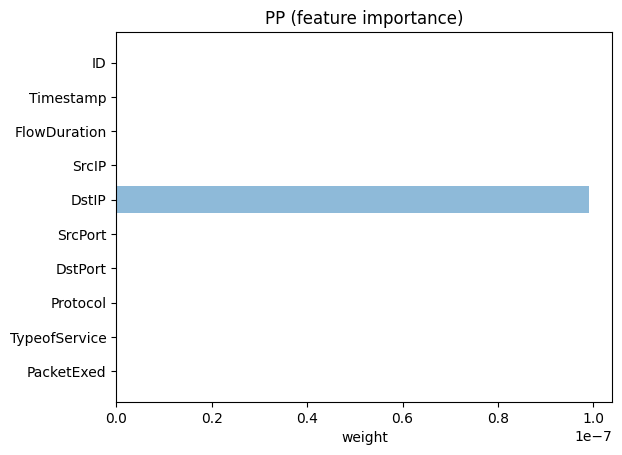

In [68]:
plt.rcdefaults()
fi = abs(Xpp_re.astype('double'))/np.std(x_train.astype('double'), axis=0) # Compute PP feature importance
    
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects)) # Get input feature names
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # Bar chart
plt.yticks(y_pos, objects) # Plot feature names on y-axis
plt.xlabel('weight') #x-label
plt.title('PP (feature importance)') # Figure heading

plt.show()    # Display the feature importance